# 1. Kurulum ve Kütüphaneler

   İlk adımda gerekli kütüphaneleri yüklüyor ve çalışma ortamı ayarlarını yapıyoruz.

In [2]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.1 MB/s eta 0:00:00a 0:00:01


In [3]:
# Gerekli kütüphanenin kurulumu
import os
import glob
import shutil
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from ultralytics import YOLO

# --- KONFİGÜRASYON ---
CONFIG = {
    'INPUT_DIR': "/kaggle/input/nusec-and-midesec/Ankara University Datasets/MiDeSeC/train images",
    'WORKING_DIR': "/kaggle/working/MiDeSeC_Project",
    'EPOCHS': 50,
    'IMG_SIZE': 1024,
    'BATCH_SIZE': 8,
    'MODEL_NAME': 'yolov8m.pt'
}

def reset_directories(base_path):
    if os.path.exists(base_path):
        try: shutil.rmtree(base_path)
        except: pass
    
    for split in ['train', 'val']:
        os.makedirs(f"{base_path}/images/{split}", exist_ok=True)
        os.makedirs(f"{base_path}/labels/{split}", exist_ok=True)
        
print("Konfigürasyon tamamlandı ve kütüphaneler yüklendi.")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Konfigürasyon tamamlandı ve kütüphaneler yüklendi.


# 2. Görüntü İşleme ve Dönüştürme Fonksiyonları

   Bu bölümde veriyi zenginleştirmek için CLAHE (Contrast Limited Adaptive Histogram Equalization)
   ve etiket formatını dönüştüren fonksiyonlar yer alır.

   CLAHE, özellikle tıbbi veya mikroskobik görüntülerde detayların (örneğin hücre sınırlarının) daha
   belirgin hale gelmesini sağlar.

In [4]:
def apply_clahe(img):
    """
    Görüntüye CLAHE (Kontrast Artırma) uygular.
    LAB renk uzayına geçip L (Luminance) kanalına histogram eşitleme yapılır.
    """
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)

def convert_polygon_to_yolo(csv_row, img_w, img_h):
    """
    CSV'den okunan poligon koordinatlarını YOLO (center_x, center_y, w, h) formatına çevirir.
    Değerler 0-1 arasına normalize edilir.
    """
    values = csv_row.dropna().values
    if len(values) < 4: return None
    
    # Koordinatları x ve y olarak ayır
    xs = values[0::2]
    ys = values[1::2]
    
    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)
    
    # Bounding Box hesapla
    w_box = x_max - x_min
    h_box = y_max - y_min
    center_x = x_min + w_box / 2
    center_y = y_min + h_box / 2
    
    # Normalize et ve YOLO string formatında döndür
    return f"0 {center_x/img_w} {center_y/img_h} {w_box/img_w} {h_box/img_h}"

# 3. Veri Setinin Hazırlanması

   Bu blok, ham görüntüleri okur, hem orijinal hallerini hem de CLAHE uygulanmış hallerini ayrı
   klasörlere kaydeder. Ayrıca etiketleri YOLO formatına çevirir.

In [5]:
def process_dataset(files, split_name, base_dir):
    print(f"--> {split_name} verisi hazırlanıyor...")
    
    for img_path in tqdm(files, desc=split_name):
        base_name = os.path.basename(img_path)
        name_no_ext = os.path.splitext(base_name)[0]
        csv_path = os.path.join(CONFIG['INPUT_DIR'], name_no_ext + ".csv")
        
        # 1. ORİJİNAL TEMİZ GÖRÜNTÜYÜ OKU
        img = cv2.imread(img_path)
        if img is None: continue
        h, w = img.shape[:2]
        
        # 2. GÖRÜNTÜLERİ KAYDET
        # Raw (Ham) Görüntü
        raw_path = f"{base_dir}/raw/images/{split_name}/{name_no_ext}.jpg"
        cv2.imwrite(raw_path, img)
        
        # CLAHE (İşlenmiş) Görüntü
        clahe_path = f"{base_dir}/clahe/images/{split_name}/{name_no_ext}.jpg"
        cv2.imwrite(clahe_path, apply_clahe(img))
        
        # 3. ETİKETLERİ OLUŞTUR
        if os.path.exists(csv_path):
            try:
                df = pd.read_csv(csv_path, header=None)
                labels = []
                for _, row in df.iterrows():
                    yolo_line = convert_polygon_to_yolo(row, w, h)
                    if yolo_line: 
                        labels.append(yolo_line)
                
                label_txt = "\n".join(labels)
                
                # Her iki veri seti için de aynı etiketi kaydet
                with open(f"{base_dir}/raw/labels/{split_name}/{name_no_ext}.txt", "w") as f: 
                    f.write(label_txt)
                with open(f"{base_dir}/clahe/labels/{split_name}/{name_no_ext}.txt", "w") as f: 
                    f.write(label_txt)
            except Exception as e: 
                print(f"Hata oluştu ({name_no_ext}): {e}")

# --- İŞLEMLERİ BAŞLAT ---
# Klasörleri sıfırla
reset_directories(f"{CONFIG['WORKING_DIR']}/raw")
reset_directories(f"{CONFIG['WORKING_DIR']}/clahe")

# Dosyaları bul ve böl
bmp_files = glob.glob(os.path.join(CONFIG['INPUT_DIR'], "*.bmp"))

if bmp_files:
    train_files, val_files = train_test_split(bmp_files, test_size=0.2, random_state=42)
    
    process_dataset(train_files, 'train', CONFIG['WORKING_DIR'])
    process_dataset(val_files, 'val', CONFIG['WORKING_DIR'])
    
    print("\nVeri hazırlığı tamamlandı.")
else:
    print("HATA: Dosyalar bulunamadı. Lütfen INPUT_DIR yolunu kontrol edin.")

--> train verisi hazırlanıyor...


train:   0%|          | 0/28 [00:00<?, ?it/s]

--> val verisi hazırlanıyor...


val:   0%|          | 0/7 [00:00<?, ?it/s]


Veri hazırlığı tamamlandı.


# 4. Model Eğitimi (Training)

Burada iki ayrı deney (Experiment) yapıyoruz:

* Exp1_Raw: Hiçbir ön işleme yapılmamış görüntülerle eğitim.
* Exp2_CLAHE: Kontrastı artırılmış görüntülerle eğitim.


In [6]:
# YAML Dosyalarını Oluştur
classes_yaml = "names: {0: 'mitosis'}"

with open("data_raw.yaml", "w") as f:
    f.write(f"path: {CONFIG['WORKING_DIR']}/raw\ntrain: images/train\nval: images/val\n{classes_yaml}")

with open("data_clahe.yaml", "w") as f:
    f.write(f"path: {CONFIG['WORKING_DIR']}/clahe\ntrain: images/train\nval: images/val\n{classes_yaml}")

# --- EĞİTİMİ BAŞLAT ---
print("--- Eğitim Başlıyor ---")

# 1. Model: RAW Data
model_raw = YOLO(CONFIG['MODEL_NAME'])
results_raw = model_raw.train(
    data='data_raw.yaml', 
    epochs=CONFIG['EPOCHS'], 
    imgsz=CONFIG['IMG_SIZE'], 
    project='MiDeSeC_Project', 
    name='Exp1_Raw', 
    verbose=False
)

# 2. Model: CLAHE Data
model_clahe = YOLO(CONFIG['MODEL_NAME'])
results_clahe = model_clahe.train(
    data='data_clahe.yaml', 
    epochs=CONFIG['EPOCHS'], 
    imgsz=CONFIG['IMG_SIZE'], 
    project='MiDeSeC_Project', 
    name='Exp2_CLAHE', 
    verbose=False
)

print("Eğitimler tamamlandı.")

--- Eğitim Başlıyor ---
Ultralytics 8.3.245 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data_raw.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=Exp1_Raw, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots

# 5. Sonuçların Karşılaştırılması ve Görselleştirme

   Eğitim bittikten sonra, hangi yöntemin (Raw vs CLAHE) daha iyi performans gösterdiğini
   grafiklerle ve metriklerle analiz ediyoruz.

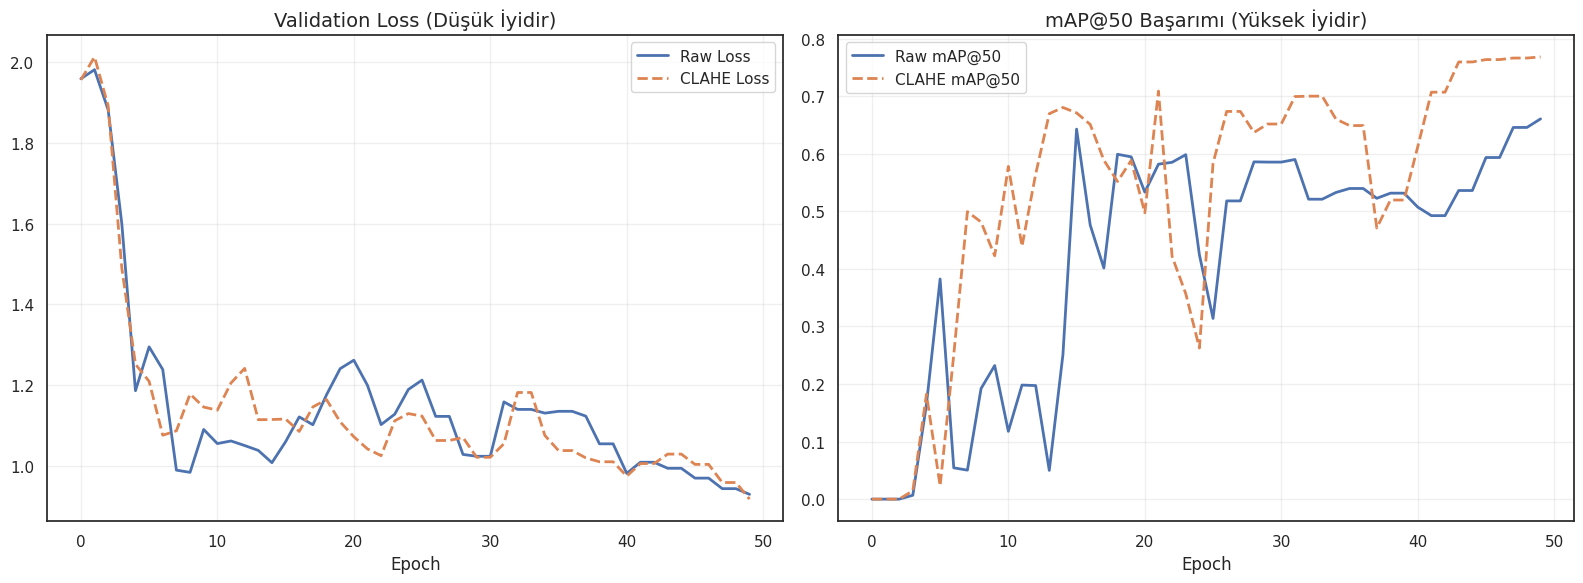

Sonuçlar derleniyor (Validation)...
Ultralytics 8.3.245 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3484.7±701.3 MB/s, size: 464.5 KB)
val: Scanning /kaggle/working/MiDeSeC_Project/raw/labels/val.cache... 7 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 7/7 1.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 1.3it/s 0.8s
                   all          7         22      0.861      0.591      0.661      0.514
Speed: 2.0ms preprocess, 79.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /kaggle/working/MiDeSeC_Project/Exp1_Raw_Val_Final
Ultralytics 8.3.245 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms

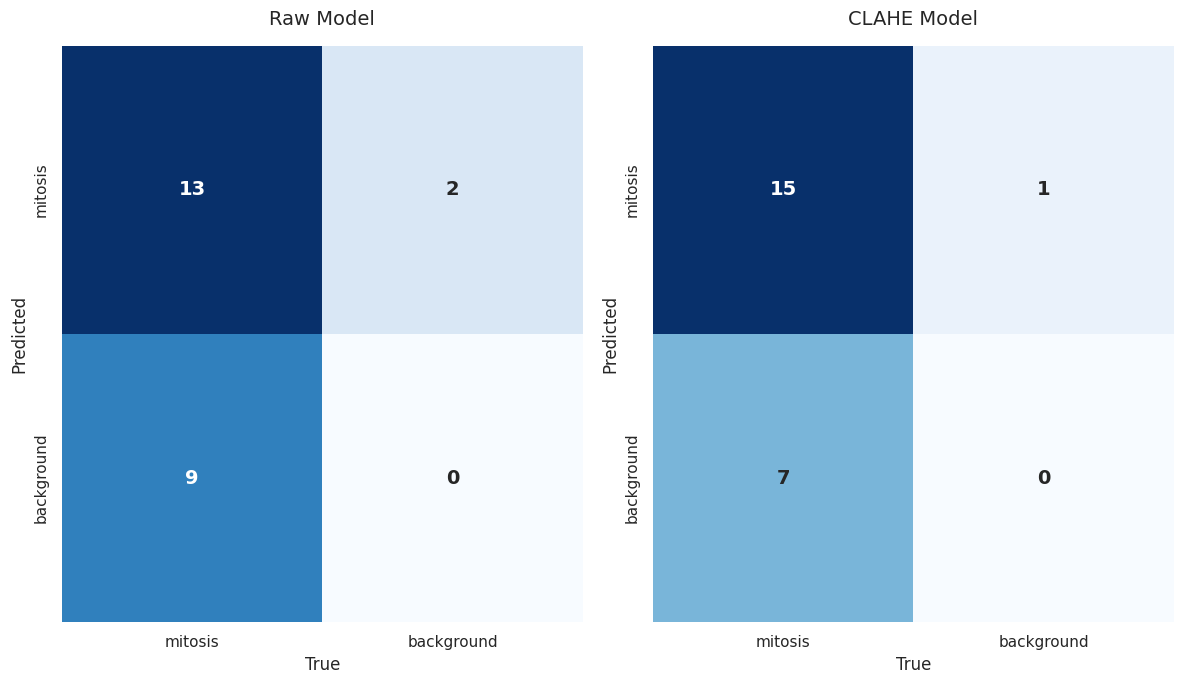

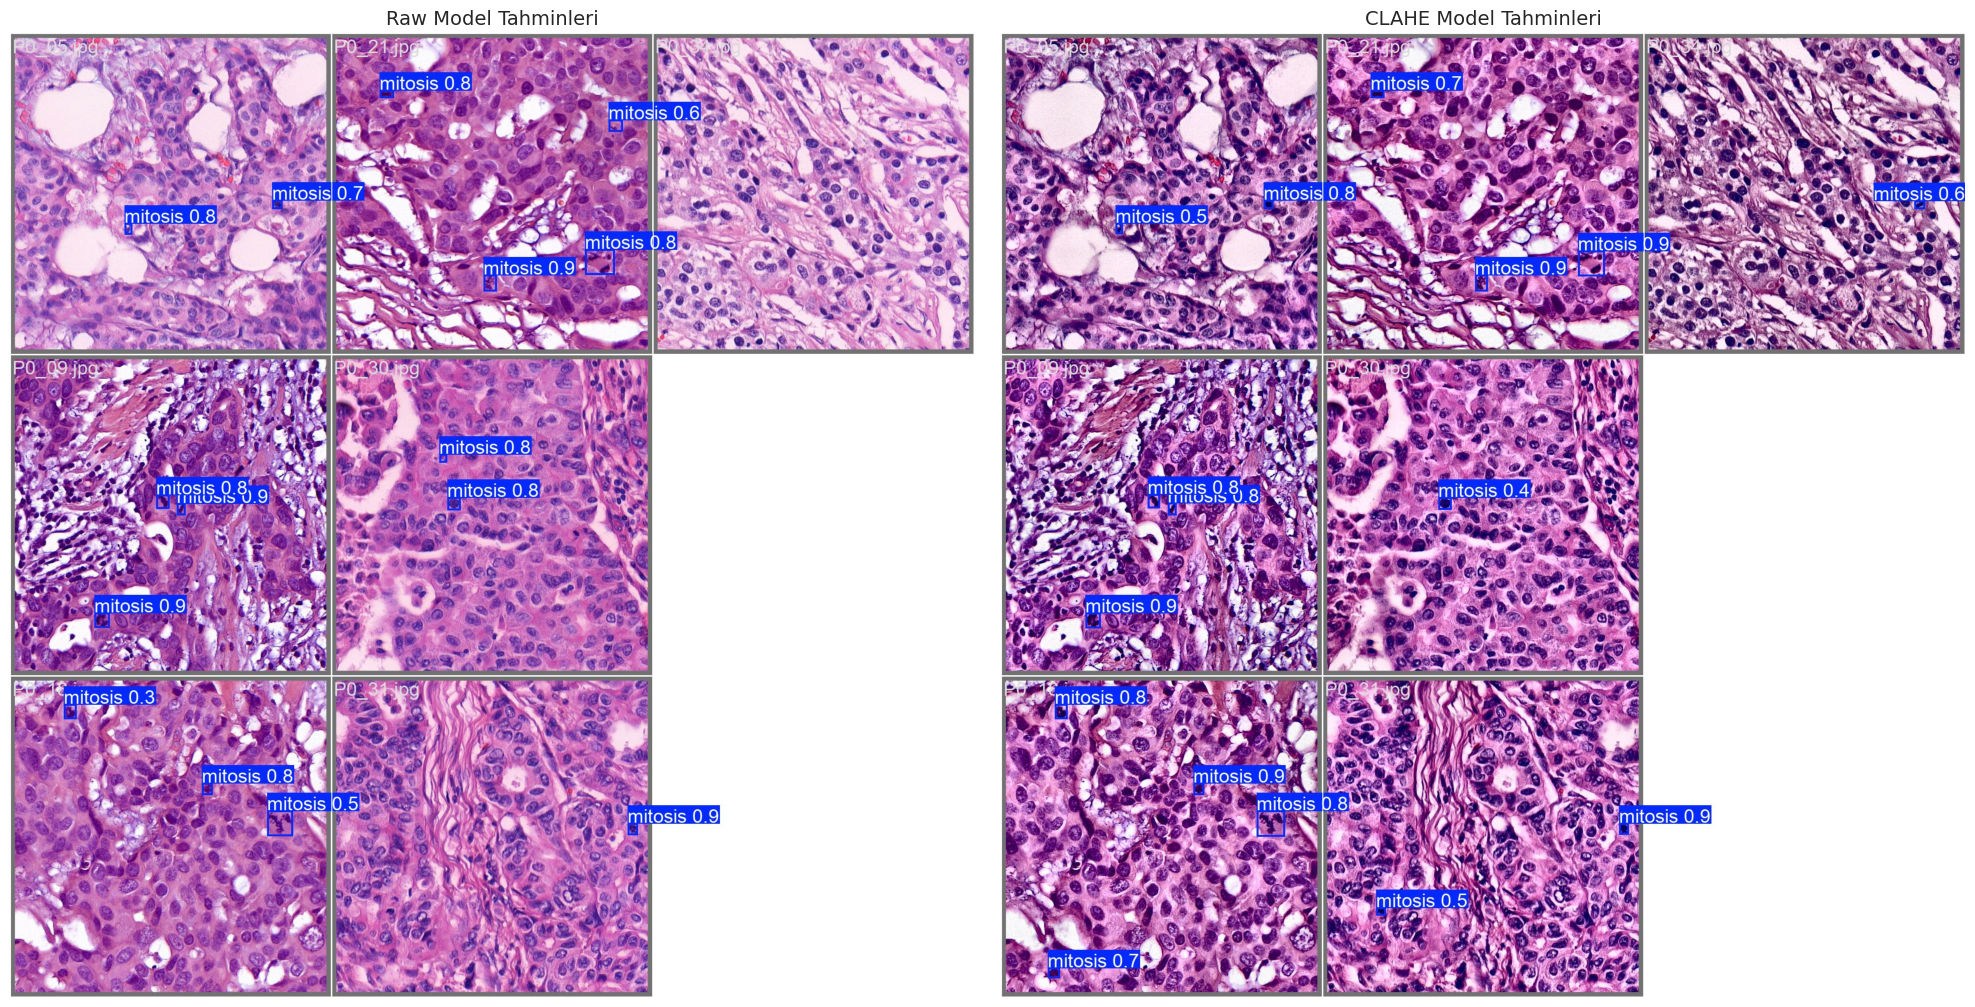

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import glob
from ultralytics import YOLO
from IPython.display import display, HTML

# --- GENEL AYARLAR ---
sns.set_theme(style="white")
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.size': 12,
    'figure.titlesize': 16,
    'axes.titlesize': 14
})

# --- YARDIMCI FONKSİYONLAR ---

def calculate_f1(precision, recall):
    return 2 * (precision * recall) / (precision + recall + 1e-6)

def color_negative_red(val):
    color = '#d65f5f' if val < 0 else '#5fba7d'
    return f'color: {color}; font-weight: bold'

def plot_training_curves(exp1_path, exp2_path):
    """Eğitim Loss ve mAP grafiklerini çizer."""
    csv1 = os.path.join(exp1_path, 'results.csv')
    csv2 = os.path.join(exp2_path, 'results.csv')
    
    if os.path.exists(csv1) and os.path.exists(csv2):
        df1 = pd.read_csv(csv1); df1.columns = [c.strip() for c in df1.columns]
        df2 = pd.read_csv(csv2); df2.columns = [c.strip() for c in df2.columns]
        
        plt.figure(figsize=(16, 6))
        
        # 1. Loss Grafiği
        plt.subplot(1, 2, 1)
        plt.plot(df1['val/box_loss'], label='Raw Loss', linewidth=2)
        plt.plot(df2['val/box_loss'], label='CLAHE Loss', linewidth=2, linestyle='--')
        plt.title("Validation Loss (Düşük İyidir)")
        plt.xlabel("Epoch"); plt.legend(); plt.grid(True, alpha=0.3)
        
        # 2. mAP Grafiği
        plt.subplot(1, 2, 2)
        plt.plot(df1['metrics/mAP50(B)'], label='Raw mAP@50', linewidth=2)
        plt.plot(df2['metrics/mAP50(B)'], label='CLAHE mAP@50', linewidth=2, linestyle='--')
        plt.title("mAP@50 Başarımı (Yüksek İyidir)")
        plt.xlabel("Epoch"); plt.legend(); plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("Grafik verileri (results.csv) bulunamadı.")

def plot_custom_confusion_matrix(metrics, ax, title):
    """Confusion Matrix'i büyük puntolarla ve çizgisiz çizer."""
    cm_data = metrics.confusion_matrix.matrix
    names = list(metrics.names.values())
    if cm_data.shape[0] > len(names): names.append("background")

    sns.heatmap(
        cm_data, annot=True, fmt='.0f', cmap='Blues', cbar=False, ax=ax,
        xticklabels=names, yticklabels=names,
        annot_kws={"size": 14, "weight": "bold"},
        linewidths=0, linecolor='white'
    )
    ax.set_title(title, pad=15)
    ax.set_ylabel('Predicted'); ax.set_xlabel('True')
    ax.grid(False)

def show_val_batch(exp_val_path, title, ax):
    """Validation sırasında üretilen val_batch0_pred.jpg dosyasını gösterir."""
    batch_path = os.path.join(exp_val_path, 'val_batch0_pred.jpg')
    
    if os.path.exists(batch_path):
        img = cv2.imread(batch_path)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(title)
        ax.axis('off')
        ax.grid(False)
    else:
        ax.text(0.5, 0.5, "Batch Görseli Bulunamadı\n(Validation çalıştırıldı mı?)", ha='center')
        ax.axis('off')

# --- ANA DASHBOARD ---
def create_final_dashboard(exp1_path, exp2_path):
    display(HTML("<h1>MiDeSeC Projesi: Final Model Raporu</h1>"))
    
    w1, w2 = f'{exp1_path}/weights/best.pt', f'{exp2_path}/weights/best.pt'
    if not (os.path.exists(w1) and os.path.exists(w2)):
        print("HATA: Model ağırlıkları bulunamadı.")
        return

    # --- BÖLÜM 1: EĞİTİM GRAFİKLERİ ---
    display(HTML("<h3>1. Eğitim Süreci Grafikleri</h3>"))
    plot_training_curves(exp1_path, exp2_path)

    # 2. VALIDATION ÇALIŞTIRMA (Verileri tazelemek için)
    print("Sonuçlar derleniyor (Validation)...")
    val_raw_dir = f'{exp1_path}_Val_Final'
    val_clahe_dir = f'{exp2_path}_Val_Final'
    
    m1 = YOLO(w1).val(data='data_raw.yaml', project='MiDeSeC_Project', name='Exp1_Raw_Val_Final', exist_ok=True, verbose=False, plots=True)
    m2 = YOLO(w2).val(data='data_clahe.yaml', project='MiDeSeC_Project', name='Exp2_CLAHE_Val_Final', exist_ok=True, verbose=False, plots=True)
    
    path1 = '/kaggle/working/MiDeSeC_Project/Exp1_Raw_Val_Final'
    path2 = '/kaggle/working/MiDeSeC_Project/Exp2_CLAHE_Val_Final'

    # --- BÖLÜM 2: SAYISAL TABLO ---
    display(HTML("<h3>2. Sayısal Performans Tablosu</h3>"))
    metrics_data = {
        'Metrik': ['mAP@50', 'Precision', 'Recall', 'F1-Score'],
        'Raw': [m1.box.map50, m1.box.mp, m1.box.mr, calculate_f1(m1.box.mp, m1.box.mr)],
        'CLAHE': [m2.box.map50, m2.box.mp, m2.box.mr, calculate_f1(m2.box.mp, m2.box.mr)]
    }
    df = pd.DataFrame(metrics_data)
    df['Fark (%)'] = ((df['CLAHE'] - df['Raw']) / df['Raw']) * 100
    
    styled_df = df.style.format({'Raw': '{:.4f}', 'CLAHE': '{:.4f}', 'Fark (%)': '{:+.2f}%'})\
      .map(color_negative_red, subset=['Fark (%)'])\
      .background_gradient(subset=['Raw', 'CLAHE'], cmap='Blues')\
      .set_properties(**{'text-align': 'center', 'padding': '8px'})
    display(styled_df)

    # --- BÖLÜM 3: CONFUSION MATRİSLERİ ---
    display(HTML("<h3>3. Confusion Matrix (Hata Matrisi)</h3>"))
    fig, axes = plt.subplots(1, 2, figsize=(12, 7))
    plot_custom_confusion_matrix(m1, axes[0], "Raw Model")
    plot_custom_confusion_matrix(m2, axes[1], "CLAHE Model")
    plt.tight_layout(); plt.show()

    # --- BÖLÜM 4: TOPLU TAHMİN GÖRSELİ (BATCH PREDICTIONS) ---
    display(HTML("<h3>4. Tahmin Görselleri</h3>"))
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    show_val_batch(path1, "Raw Model Tahminleri", axes[0])
    show_val_batch(path2, "CLAHE Model Tahminleri", axes[1])
    plt.tight_layout(); plt.show()

# --- ÇALIŞTIR ---
base_exp = '/kaggle/working/MiDeSeC_Project'
create_final_dashboard(f'{base_exp}/Exp1_Raw', f'{base_exp}/Exp2_CLAHE')